#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the plotting and viewing of different results:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from itertools import product
from IPython.display import display, HTML

### Code for getting nice tables for paper in single n single p cases

In [2]:
def smart_fmt_single_setting(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary_single_setting(metric_dict, metrics, methods, settings):
    """
    Build a compact summary for the single-setting case.

    Returns: dict keyed as "{metric}_{method}_{setting_value}" -> [mean, min, max]
    Example key: "mse_beta_TAVIE_1000"
    """
    if len(settings) != 1:
        raise ValueError("metrics_summary_single_setting expects exactly one setting.")
    sval = settings[0]

    res = {}
    for metric, method in product(metrics, methods):
        dict_key = f"{metric}_{method}"
        # For single setting, metric_dict[dict_key] should be an array-like of repetitions
        arr = np.asarray(metric_dict[dict_key], dtype=float).ravel()
        mu, mn, mx = np.nanmean(arr), np.nanmin(arr), np.nanmax(arr)
        res[f"{metric}_{method}_{sval}"] = [mu, mn, mx]
    return res

# ---------- HTML table (rows = methods, cols = metrics) ----------
def build_html_table_single_setting(summary,
                                    metrics, metric_display,
                                    methods, method_display):
    """
    Returns a DataFrame whose index = method display names and columns = metric display names.
    Each cell contains HTML with mean on top and (min, max) below.
    """
    # Infer the single setting value from any key in the summary
    if not summary:
        raise ValueError("Empty summary passed to build_html_table_single_setting.")
    # Pull one key and parse the trailing setting token
    example_key = next(iter(summary))
    sval = example_key.split("_")[-1]

    rows = []
    for meth_id, meth_disp in zip(methods, method_display):
        cell_vals = {}
        for met_id, met_disp in zip(metrics, metric_display):
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cell_vals[met_disp] = (
                    f"{smart_fmt_single_setting(mu)}"
                    f"<br>({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})"
                )
            else:
                cell_vals[met_disp] = "--"
        rows.append((meth_disp, cell_vals))

    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index.name = "Methods"
    # Nice HTML display (line breaks inside cells)
    display(HTML(df.to_html(escape=False)))
    return df  # also return the DataFrame if you need to style further


def to_latex_single_setting(summary,
                            metrics, metric_display,
                            methods, method_display,
                            caption=None, label="tab:single-setting",
                            fontsize="\\small", arraystretch=1.1):
    """
    Longtable where:
      - Column 1: Methods
      - Columns 2..K: metrics (each cell shows mean with min/max beneath via \\makecell)
    Required LaTeX packages: longtable, booktabs, makecell
    """
    if not summary:
        raise ValueError("Empty summary passed to to_latex_single_setting.")

    # Column spec: one left col for methods, then centered metric columns
    k = len(metrics)
    colspec = "l" + "c" * k

    if caption is None:
        caption = "Results by method."

    # Header rows
    head_top = []
    head_top.append("\\toprule")
    metric_head = " & ".join(metric_display)
    head_top.append(f"Methods & {metric_head} \\\\")
    head_top.append("\\midrule")
    head_repeat = head_top.copy()

    # Footer rows
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{1+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Build table lines
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}} \\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Get the single setting value from any key
    sval = next(iter(summary)).split("_")[-1]

    # Body: each row = method, cells = metrics
    for meth_id, meth_disp in zip(methods, method_display):
        cells = []
        for met_id in metrics:
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cells.append(
                    f"\\makecell[c]{{{smart_fmt_single_setting(mu)}\\\\"
                    f"({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})}}"
                )
            else:
                cells.append("--")
        lines.append(meth_disp + " & " + " & ".join(cells) + " \\\\")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")

    return "\n".join(lines)


### Code for getting nice tables for paper in multi n single p and single n multi p cases

In [3]:
def smart_fmt(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary(metric_dict, metrics, methods, settings):
    """Build dict {metric_method_setting: [mean, min, max]} from raw metric_dict."""
    setting_no = range(len(settings))
    res_dict = {}
    for metric, method, setting in product(metrics, methods, setting_no):
        dict_key = f"{metric}_{method}"
        if len(settings) == 1:
            temp = metric_dict[dict_key]
        else:
            temp = metric_dict[dict_key][setting]
        res_dict[f"{metric}_{method}_{settings[setting]}"] = [temp.mean(), temp.min(), temp.max()]
    return res_dict

# ---------- Simple HTML display table (unchanged) ----------
def build_tables_from_summary(summary, metrics, metric_display, methods, method_display,
                              settings, settings_name="n", for_latex=False):
    rows = []
    for metric, metric_disp in zip(metrics, metric_display):
        for method, method_disp in zip(methods, method_display):
            cell_vals = {}
            for n in settings:
                key = f"{metric}_{method}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    if for_latex:
                        # we'll ignore this for LaTeX now (we generate LaTeX manually)
                        cell_vals[n] = f"{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})"
                    else:
                        cell_vals[n] = f"{smart_fmt(mu)}<br>({smart_fmt(mn)}, {smart_fmt(mx)})"
                else:
                    cell_vals[n] = "--"
            rows.append(((metric_disp, method_disp), cell_vals))
    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Metric", "Method"])
    df = df[settings]  # enforce column order
    df.columns.name = settings_name
    display(HTML(df.to_html(escape=False)))
    return df

# ---------- CLEAN LaTeX generator (manual; tidy) ----------
def to_latex_from_summary_clean(summary,
                                metrics, metric_display,
                                methods, method_display,
                                settings, settings_name="n",
                                caption=None, label="tab:mean-range",
                                fontsize="\\small", arraystretch=1.15):
    """
    Generates a clean longtable:
      - First column: Metric (multirow over methods)
      - Second column: Method
      - Remaining columns: settings values
      - Each data cell uses \\makecell[r]{mean\\(min, max)} for stacked lines
    Requires LaTeX packages: longtable, booktabs, multirow, makecell
    """
    k = len(settings)
    # Column format: Metric (l), Method (l), then k right-aligned numeric columns
    colspec = "ll" + "c" * k

    # Caption default
    if caption is None:
        n_list = ", ".join(map(str, settings))
        caption = rf"Mean and range across repetitions; columns are {settings_name} $\in\{{{n_list}\}}$."

    # Header (appears at table top and on continued pages)
    head_top = []
    head_top.append("\\toprule")
    # First header row: blank over Metric/Method headers then the settings values
    settings_head = " & ".join(str(s) for s in settings)
    head_top.append(f" &  & \\multicolumn{{{k}}}{{c}}{{{settings_name}}} \\\\")
    head_top.append("\\cmidrule(lr){" + f"3-{2+k}" + "}")
    head_top.append(f"Metric & Method & {settings_head} \\\\")
    head_top.append("\\midrule")

    head_repeat = head_top.copy()
    head_repeat[0] = "\\toprule"  # same styling on new pages

    # Footer on continued pages
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{2+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Begin building table
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,multirow,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}}\\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Body: for each metric group, multirow across the number of methods
    for m_disp, m_id in zip(metric_display, metrics):
        group_rows = []
        for meth_disp, meth_id in zip(method_display, methods):
            cells = []
            for n in settings:
                key = f"{m_id}_{meth_id}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    cells.append(f"\\makecell[c]{{{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})}}")
                else:
                    cells.append("--")
            group_rows.append((meth_disp, cells))

        # Write first row with \multirow{len(methods)}{*}{Metric}
        first_meth, first_cells = group_rows[0]
        lines.append(f"\\multirow{{{len(group_rows)}}}{{*}}{{{m_disp}}} & {first_meth} & " +
                     " & ".join(first_cells) + " \\\\")
        # Remaining methods in the group
        for meth_disp, cells in group_rows[1:]:
            lines.append(f" & {meth_disp} & " + " & ".join(cells) + " \\\\")
        # Add a little breathing room between groups
        lines.append("\\hline")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")  # close font size group

    latex_code = "\n".join(lines)
    return latex_code

## Reading the results for Laplace and plotting

### Laplace SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000, p=5)

In [4]:
n = 1000
p = 5
path1 = f'results_compete/Laplace_metrics_n_{n}_p_{p}.pkl'

metrics_df_1 = pd.read_pickle(path1)

mse_beta_TAVIE = metrics_df_1['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_1['mse_tau2_TAVIE']
time_TAVIE = metrics_df_1['time_TAVIE']

mse_beta_DADVI = metrics_df_1['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_1['mse_tau2_DADVI']
time_DADVI = metrics_df_1['time_DADVI']

mse_beta_ADVI_mf = metrics_df_1['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_1['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_1['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_1['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_1['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_1['time_ADVI_fr']

mse_beta_NUTS = metrics_df_1['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_1['mse_tau2_NUTS']
time_NUTS = metrics_df_1['time_NUTS']

# avg_metrics = {
#     "TAVIE": {r"MSE of $\beta$": mse_beta_TAVIE, r"MSE of $\tau^2$": mse_tau2_TAVIE, "run-time": time_TAVIE},
#     "DADVI": {r"MSE of $\beta$": mse_beta_DADVI, r"MSE of $\tau^2$": mse_tau2_DADVI, "run-time": time_DADVI},
#     "ADVI MF": {r"MSE of $\beta$": mse_beta_ADVI_mf, r"MSE of $\tau^2$": mse_tau2_ADVI_mf, "run-time": time_ADVI_mf},
#     "ADVI FR": {r"MSE of $\beta$": mse_beta_ADVI_fr, r"MSE of $\tau^2$": mse_tau2_ADVI_fr, "run-time": time_ADVI_fr},
#     "NUTS": {r"MSE of $\beta$": mse_beta_NUTS, r"MSE of $\tau^2$": mse_tau2_NUTS, "run-time": time_NUTS},
# }

# avg = {
#     method: {
#         k: float(np.mean(np.asarray(v)))   # robust to list/Series/ndarray
#         for k, v in vals.items()
#     }
#     for method, vals in avg_metrics.items()
# }

# print(f'Average metrics for Laplace SSG with (n,p)=({n},{p})')
# avg_df = pd.DataFrame(avg).T  # rows=methods, cols=mse_beta/mse_tau2/time
# abs_dev = deviation_tables(avg_metrics)
# format_pm(avg_df, abs_dev)

# 1) Build summary (exactly one setting)
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE($\beta$)", r"MSE($\tau^2$)", "Time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI MF", "ADVI FR", "NUTS"]
settings = [10000]  # single setting only

summary = metrics_summary_single_setting(metrics_df_1, metrics, methods, settings)

# 2) HTML table in Jupyter
df_html = build_html_table_single_setting(summary, metrics, metric_display, methods, method_display)

# 3) LaTeX longtable code
latex_code = to_latex_single_setting(
    summary, metrics, metric_display, methods, method_display,
    caption="Results for Laplace SSG at (n,p) = (1000, 5)",
    label="tab:single-setting"
)
#print(latex_code)

,MSE($\beta$),MSE($\tau^2$),Time (s)
Methods,,,
TAVIE,"3.807e-04(9.064e-05, 1.038e-03)","3.417e-02(8.571e-08, 1.811e-01)","7.248e-03(5.805e-03, 1.082e-02)"
DADVI,"3.832e-04(9.972e-05, 1.115e-03)","3.381e-02(3.354e-05, 2.684e-01)","1.324e+00(1.266e+00, 1.581e+00)"
ADVI MF,"4.344e-04(6.641e-05, 1.479e-03)","1.169e-01(5.673e-08, 1.122e+00)","6.635e+00(5.309e+00, 7.448e+00)"
ADVI FR,"4.478e-04(8.913e-05, 1.537e-03)","1.056e-01(2.012e-04, 6.573e-01)","1.018e+01(8.654e+00, 1.140e+01)"
NUTS,"3.770e-04(9.435e-05, 1.057e-03)","3.449e-02(0.000e+00, 2.992e-01)","2.450e+00(2.275e+00, 2.675e+00)"


/var/folders/w0/38zdqgkd1dlclgzfl906wb400000gn/T/ipykernel_13938/2828982516.py:7: RuntimeWarning: divide by zero encountered in log
  axes[0].boxplot([np.log(mse_tau2_TAVIE), np.log(mse_tau2_DADVI), np.log(mse_tau2_ADVI_mf), np.log(mse_tau2_ADVI_fr), np.log(mse_tau2_NUTS)],


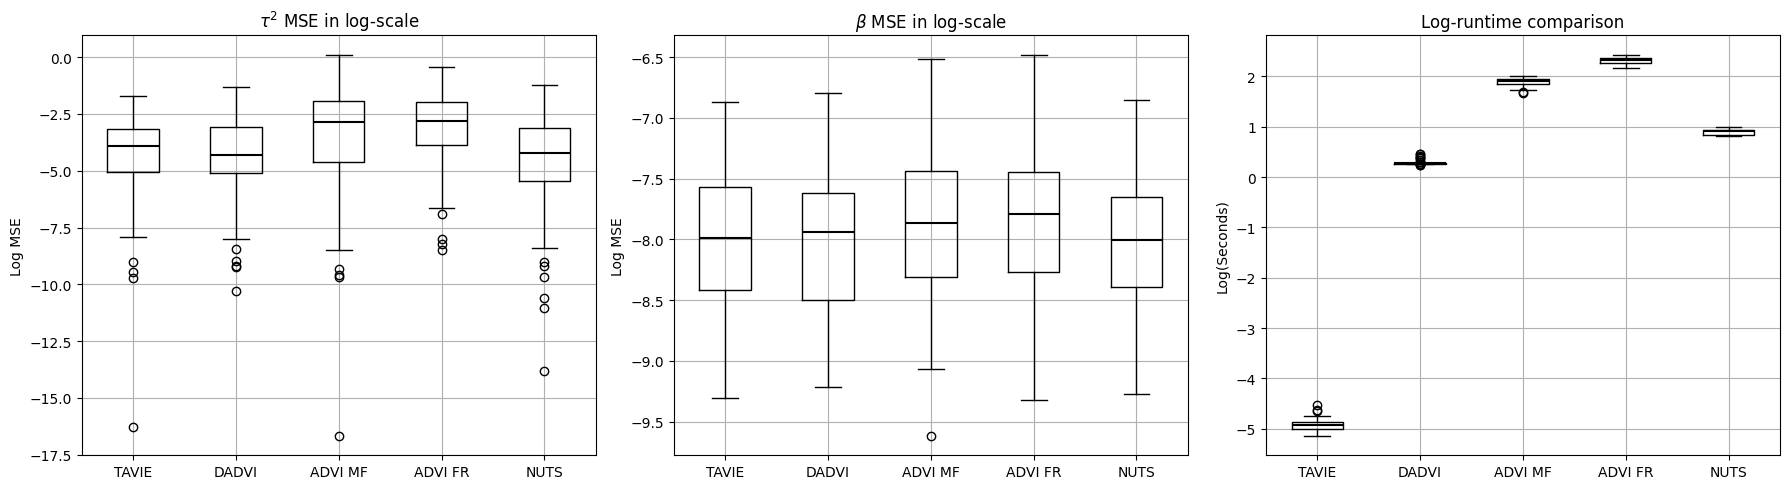

In [5]:
# plotting the results for TAVIE, DADVI, BBVI, and NUTS

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# Tau^2 MSE comparison
axes[0].boxplot([np.log(mse_tau2_TAVIE), np.log(mse_tau2_DADVI), np.log(mse_tau2_ADVI_mf), np.log(mse_tau2_ADVI_fr), np.log(mse_tau2_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[0].set_title(r'$\tau^2$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([np.log(mse_beta_TAVIE), np.log(mse_beta_DADVI), np.log(mse_beta_ADVI_mf), np.log(mse_beta_ADVI_fr), np.log(mse_beta_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[1].set_title(r'$\beta$ MSE in log-scale')
axes[1].set_ylabel('Log MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_DADVI), np.log(time_ADVI_mf), np.log(time_ADVI_fr), np.log(time_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
fig.savefig(f'results_compete/plots/Laplace_metrics_n_{n}_p_{p}_better.png', dpi=300, bbox_inches='tight')
plt.show()

### Laplace SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [6]:
p = 5  # <-- set this to whatever you used
path2 = f"results_compete/Laplace_metrics_multi_n_p_{p}.pkl"

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_2['mse_tau2_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_2['mse_tau2_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_2['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_2['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_2['mse_tau2_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [7]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)

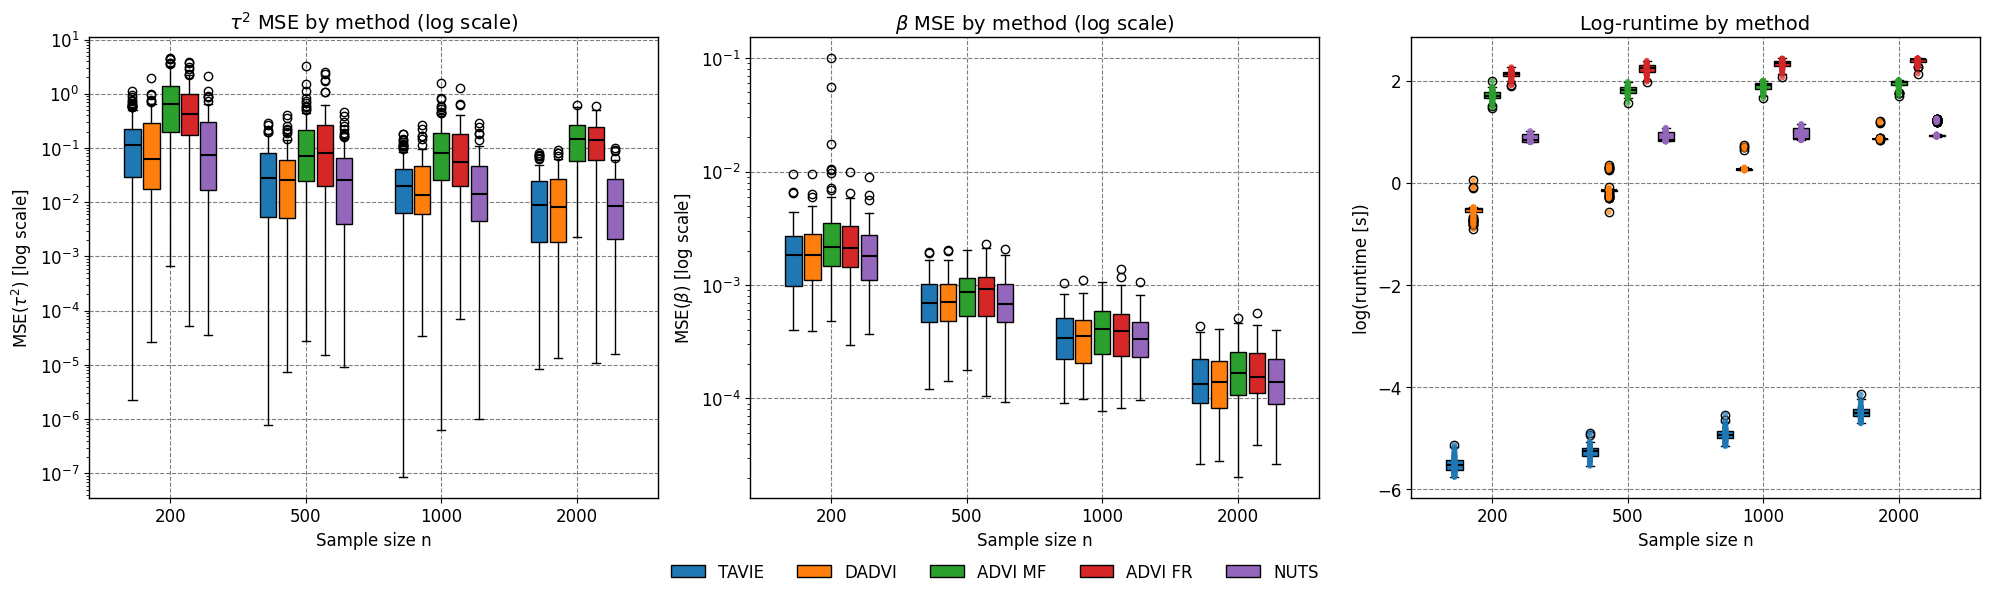

In [8]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over the choice of different sample sizes n

methods  = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2',      'C3',      'C4']
n_sizes  = len(sample_sizes)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.5    # gap between n-groups on the x-axis (↑ for bigger gaps)
method_step   = 0.35   # separation between methods within each group
box_width     = 0.3    # visual width of each box
centers       = np.arange(n_sizes) * group_spacing  # group centers for each n

fig, axes = plt.subplots(1, 3, figsize=(20, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=12, color='black')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=12, color='black')
ax.set_title(r'$\tau^2$ MSE by method (log scale)', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=12, color='black')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12, color='black')
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log scale on the data) + overlay per-run times
ax = axes[2]
eps = 1e-16
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

    # overlay the true (per-run) times as points (logged)
    for i in range(n_sizes):
        yvals = np.log(np.clip(arr[i, :], eps, None))
        xvals = np.full_like(yvals, positions[i], dtype=float)
        # optional slight jitter to reduce overlap:
        # xvals = positions[i] + 0.02 * np.random.randn(len(yvals))
        ax.scatter(xvals, yvals, s=18, alpha=0.7, color=colors[j], edgecolors='none', zorder=3)

ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', fontsize=12, color='black')
ax.set_ylabel('log(runtime [s])', fontsize=12, color='black')
ax.set_title('Log-runtime by method', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_n_p_{p}_better.png', dpi=300, bbox_inches='tight')
plt.show()


### Laplace SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000; p=[3,4,5,6])

In [9]:
n = 1000
path3 = f'results_compete/Laplace_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_3['mse_tau2_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_3['mse_tau2_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_3['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_3['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_3['mse_tau2_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [10]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3, 4, 5, 6]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)

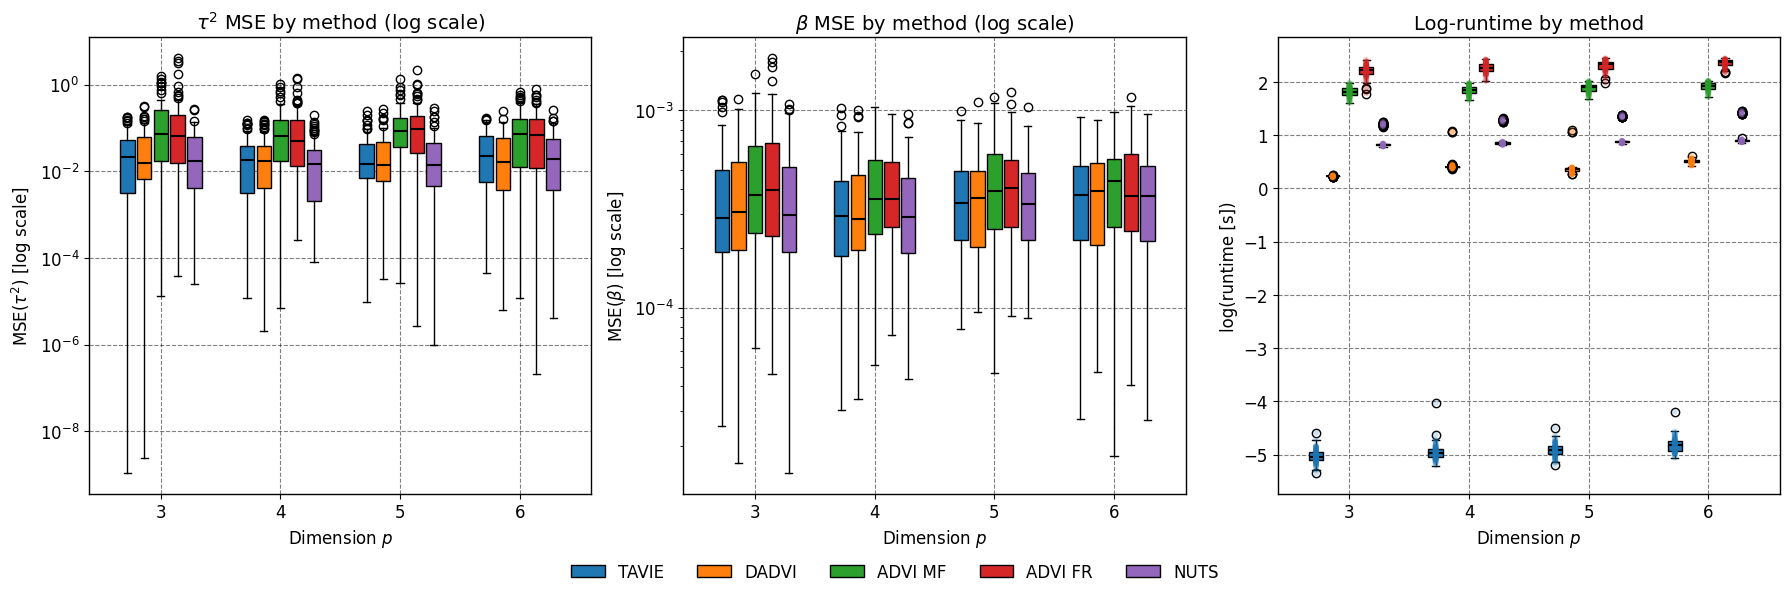

In [11]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over the choice of different features choices p
methods   = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors    = ['C0',    'C1',    'C2',      'C3',      'C4']
P         = len(p_values)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.5    # gap between p-groups on x-axis
method_step   = 0.35   # separation between methods within each group
box_width     = 0.30   # width of each box
centers       = np.arange(P) * group_spacing

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Style
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', fontsize=12, color='black')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=12, color='black')
ax.set_title(r'$\tau^2$ MSE by method (log scale)', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', fontsize=12, color='black')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12, color='black')
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log on the DATA; linear axis) + overlay true runs
ax = axes[2]
eps = 1e-16
series_time = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
for j, arr in enumerate(series_time):
    # boxplots use log of the times
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay true per-run times as points (logged), no jitter
    for i in range(P):
        yvals = np.log(np.clip(arr[i, :], eps, None))
        xvals = np.full_like(yvals, positions[i], dtype=float)
        ax.scatter(xvals, yvals, s=18, alpha=0.2, color=colors[j],
                   edgecolors='none', zorder=3)

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', fontsize=12, color='black')
ax.set_ylabel('log(runtime [s])', fontsize=12, color='black')
ax.set_title('Log-runtime by method', fontsize=14, color='black')
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# Legend
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_p_n_{n}_better.png', dpi=300, bbox_inches='tight')
plt.show()

## Reading the results for Student's-t

### Student's-t SSG: TAVIE, MFVI, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000, p=5)

In [12]:
n = 1000
p = 5
path1 = f'results_compete/Student_metrics_n_{n}_p_{p}.pkl'

metrics_df_1 = pd.read_pickle(path1)

mse_beta_TAVIE = metrics_df_1['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_1['mse_tau2_TAVIE']
time_TAVIE = metrics_df_1['time_TAVIE']

mse_beta_MFVI = metrics_df_1['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_1['mse_tau2_MFVI']
time_MFVI = metrics_df_1['time_MFVI']

mse_beta_DADVI = metrics_df_1['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_1['mse_tau2_DADVI']
time_DADVI = metrics_df_1['time_DADVI']

mse_beta_ADVI_mf = metrics_df_1['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_1['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_1['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_1['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_1['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_1['time_ADVI_fr']

mse_beta_NUTS = metrics_df_1['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_1['mse_tau2_NUTS']
time_NUTS = metrics_df_1['time_NUTS']

# avg_metrics = {
#     "TAVIE": {r"MSE of $\beta$": mse_beta_TAVIE, r"MSE of $\tau^2$": mse_tau2_TAVIE, "run-time": time_TAVIE},
#     "MFVI": {r"MSE of $\beta$": mse_beta_MFVI, r"MSE of $\tau^2$": mse_tau2_MFVI, "run-time": time_MFVI},
#     "DADVI": {r"MSE of $\beta$": mse_beta_DADVI, r"MSE of $\tau^2$": mse_tau2_DADVI, "run-time": time_DADVI},
#     "ADVI MF": {r"MSE of $\beta$": mse_beta_ADVI_mf, r"MSE of $\tau^2$": mse_tau2_ADVI_mf, "run-time": time_ADVI_mf},
#     "ADVI FR": {r"MSE of $\beta$": mse_beta_ADVI_fr, r"MSE of $\tau^2$": mse_tau2_ADVI_fr, "run-time": time_ADVI_fr},
#     "NUTS": {r"MSE of $\beta$": mse_beta_NUTS, r"MSE of $\tau^2$": mse_tau2_NUTS, "run-time": time_NUTS},
# }

# avg = {
#     method: {
#         k: float(np.mean(np.asarray(v)))   # robust to list/Series/ndarray
#         for k, v in vals.items()
#     }
#     for method, vals in avg_metrics.items()
# }

# print(f"Average metrics for Student's-t SSG with (n,p)=({n},{p})")
# avg_df = pd.DataFrame(avg).T  # rows=methods, cols=mse_beta/mse_tau2/time
# abs_dev = deviation_tables(avg_metrics)
# format_pm(avg_df, abs_dev)

# 1) Build summary (exactly one setting)
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE($\beta$)", r"MSE($\tau^2$)", "Time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI MF", "ADVI FR", "NUTS"]
settings = [1000]  # single setting only

summary = metrics_summary_single_setting(metrics_df_1, metrics, methods, settings)

# 2) HTML table in Jupyter
df_html = build_html_table_single_setting(summary, metrics, metric_display, methods, method_display)

# 3) LaTeX longtable code
latex_code = to_latex_single_setting(
    summary, metrics, metric_display, methods, method_display,
    caption="Results by method at (n,p) = (1000, 5)",
    label="tab:single-setting"
)
# print(latex_code)

,MSE($\beta$),MSE($\tau^2$),Time (s)
Methods,,,
TAVIE,"5.140e-04(8.158e-05, 1.525e-03)","2.425e-02(7.915e-06, 1.801e-01)","3.255e-03(2.939e-03, 7.412e-03)"
MFVI,"5.177e-04(7.724e-05, 1.506e-03)","5.451e-02(3.043e-05, 3.156e-01)","2.155e-02(1.091e-02, 5.851e-02)"
DADVI,"5.266e-04(7.458e-05, 1.569e-03)","2.225e-02(1.811e-05, 1.501e-01)","5.480e-01(5.131e-01, 1.050e+00)"
ADVI MF,"5.439e-04(1.136e-04, 1.386e-03)","1.173e-01(1.805e-07, 5.924e-01)","7.067e+00(5.662e+00, 8.167e+00)"
ADVI FR,"5.800e-04(3.322e-05, 1.728e-03)","1.519e-01(2.669e-05, 1.565e+00)","1.057e+01(8.076e+00, 1.198e+01)"
NUTS,"5.128e-04(7.464e-05, 1.525e-03)","2.230e-02(1.000e-06, 1.406e-01)","2.753e+00(2.524e+00, 3.276e+00)"


### Student's-t SSG: TAVIE, MFVI, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [13]:
p = 5  # <-- set this to whatever you used
path2 = f"results_compete/Student_metrics_multi_n_p_{p}.pkl"

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_2['mse_tau2_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_MFVI = metrics_df_2['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_2['mse_tau2_MFVI']
time_MFVI = metrics_df_2['time_MFVI']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_2['mse_tau2_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_2['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_2['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_2['mse_tau2_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [14]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size (n)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)

In [15]:
n = 1000
path3 = f'results_compete/Student_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
mse_tau2_TAVIE = metrics_df_3['mse_tau2_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_MFVI = metrics_df_3['mse_beta_MFVI']
mse_tau2_MFVI = metrics_df_3['mse_tau2_MFVI']
time_MFVI = metrics_df_3['time_MFVI']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
mse_tau2_DADVI = metrics_df_3['mse_tau2_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
mse_tau2_ADVI_mf = metrics_df_3['mse_tau2_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
mse_tau2_ADVI_fr = metrics_df_3['mse_tau2_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
mse_tau2_NUTS = metrics_df_3['mse_tau2_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [16]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Run-time (s)"]
methods = ["TAVIE", "MFVI", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "MFVI", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3,4,5,6]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Student's-$t$ SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)

## Reading the results for Negative-Binomial

### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000 and p=5)

In [17]:
n = 1000
p = 5
path1 = f'results_compete/NegBin_metrics_n_{n}_p_{p}.pkl'

metrics_df_1 = pd.read_pickle(path1)

mse_beta_TAVIE = metrics_df_1['mse_beta_TAVIE']
time_TAVIE = metrics_df_1['time_TAVIE']

mse_beta_DADVI = metrics_df_1['mse_beta_DADVI']
time_DADVI = metrics_df_1['time_DADVI']

mse_beta_ADVI_mf = metrics_df_1['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_1['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_1['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_1['time_ADVI_fr']

mse_beta_NUTS = metrics_df_1['mse_beta_NUTS']
time_NUTS = metrics_df_1['time_NUTS']

# avg_metrics = {
#     "TAVIE": {r"MSE of $\beta$": mse_beta_TAVIE, "run-time": time_TAVIE},
#     "DADVI": {r"MSE of $\beta$": mse_beta_DADVI, "run-time": time_DADVI},
#     "ADVI MF": {r"MSE of $\beta$": mse_beta_ADVI_mf, "run-time": time_ADVI_mf},
#     "ADVI FR": {r"MSE of $\beta$": mse_beta_ADVI_fr, "run-time": time_ADVI_fr},
#     "NUTS": {r"MSE of $\beta$": mse_beta_NUTS, "run-time": time_NUTS},
# }

# avg = {
#     method: {
#         k: float(np.mean(np.asarray(v)))   # robust to list/Series/ndarray
#         for k, v in vals.items()
#     }
#     for method, vals in avg_metrics.items()
# }

# print(f'Average metrics for Negative-Binomial SSG with (n,p)=({n},{p})')
# avg_df = pd.DataFrame(avg).T  # rows=methods, cols=mse_beta/mse_tau2/time
# abs_dev = deviation_tables(avg_metrics)
# format_pm(avg_df, abs_dev)

# 1) Build summary (exactly one setting)
metrics = ["mse_beta", "time"]
metric_display = [r"MSE($\beta$)", "Time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI MF", "ADVI FR", "NUTS"]
settings = [10000]  # single setting only

summary = metrics_summary_single_setting(metrics_df_1, metrics, methods, settings)

# 2) HTML table in Jupyter
df_html = build_html_table_single_setting(summary, metrics, metric_display, methods, method_display)

# 3) LaTeX longtable code
latex_code = to_latex_single_setting(
    summary, metrics, metric_display, methods, method_display,
    caption="Results by method at (n,p) = (1000, 5)",
    label="tab:single-setting"
)
# print(latex_code)

,MSE($\beta$),Time (s)
Methods,,
TAVIE,"2.697e-04(3.526e-05, 1.022e-03)","1.870e-03(1.718e-03, 2.261e-03)"
DADVI,"2.714e-04(1.842e-05, 9.472e-04)","4.505e-01(3.751e-01, 7.071e-01)"
ADVI MF,"3.568e-04(3.977e-05, 1.998e-03)","1.935e+00(1.915e+00, 2.008e+00)"
ADVI FR,"3.969e-04(4.084e-05, 1.686e-03)","7.186e+00(5.849e+00, 7.925e+00)"
NUTS,"2.703e-04(3.504e-05, 1.033e-03)","3.943e+00(3.778e+00, 4.272e+00)"


### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=[200,500,1000,2000]; p=5)

In [19]:
p = 5  # <-- set this to whatever you used
path2 = f'results_compete/NegBin_metrics_multi_n_p_{p}.pkl'

metrics_df_2 = pd.read_pickle(path2)
sample_sizes = metrics_df_2['n']

mse_beta_TAVIE = metrics_df_2['mse_beta_TAVIE']
time_TAVIE = metrics_df_2['time_TAVIE']

mse_beta_DADVI = metrics_df_2['mse_beta_DADVI']
time_DADVI = metrics_df_2['time_DADVI']

mse_beta_ADVI_mf = metrics_df_2['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_2['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_2['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_2['time_ADVI_fr']

mse_beta_NUTS = metrics_df_2['mse_beta_NUTS']
time_NUTS = metrics_df_2['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [20]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_2
metrics = ["mse_beta", "time"]
metric_display = [r"MSE of $\beta$",  "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [200, 500, 1000, 2000]
settings_name = "Sample Size"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)

### Negative-Binomial SSG: TAVIE, DADVI, ADVI MF, ADVI FR, and NUTS (n=1000; p=[3,4,5,6])

In [21]:
n = 1000
path3 = f'results_compete/NegBin_metrics_multi_p_n_{n}.pkl'

metrics_df_3 = pd.read_pickle(path3)
p_values = metrics_df_3['p']

mse_beta_TAVIE = metrics_df_3['mse_beta_TAVIE']
time_TAVIE = metrics_df_3['time_TAVIE']

mse_beta_DADVI = metrics_df_3['mse_beta_DADVI']
time_DADVI = metrics_df_3['time_DADVI']

mse_beta_ADVI_mf = metrics_df_3['mse_beta_ADVI_mf']
time_ADVI_mf = metrics_df_3['time_ADVI_mf']

mse_beta_ADVI_fr = metrics_df_3['mse_beta_ADVI_fr']
time_ADVI_fr = metrics_df_3['time_ADVI_fr']

mse_beta_NUTS = metrics_df_3['mse_beta_NUTS']
time_NUTS = metrics_df_3['time_NUTS']

methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']

In [22]:
# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df_3
metrics = ["mse_beta", "time"]
metric_display = [r"MSE of $\beta$", "Run-time (s)"]
methods = ["TAVIE", "DADVI", "ADVI_mf", "ADVI_fr", "NUTS"]
method_display = ["TAVIE", "DADVI", "ADVI (MF)", "ADVI (FR)", "PyMC (NUTS)"]
settings = [3, 4, 5, 6]
settings_name = "Dimension (p)"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Negative-Binomial SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
# print(latex_code)